In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [5]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [6]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-3.0144, -2.8155, -2.9723, -2.9875, -2.8494, -2.9118, -3.0075, -2.7416,
         -2.9491, -2.8144, -2.9107, -2.8378, -2.8491, -2.8719, -2.9033, -2.8689,
         -2.8871, -2.8797]], grad_fn=<LogSoftmaxBackward0>)


In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Czech / line = Jaluvka
category = Chinese / line = Xie
category = Greek / line = Tselios
category = Spanish / line = Reyes
category = Czech / line = Jelinek
category = Vietnamese / line = Ha
category = French / line = Beaulieu
category = Polish / line = Slusarczyk
category = Polish / line = Marek
category = Irish / line = Aonghuis


In [9]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()




In [10]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 18s) 3.0052 Wolstencroft / Italian ✗ (English)
10000 10% (0m 34s) 4.5671 Seif / Korean ✗ (Arabic)
15000 15% (0m 51s) 1.8739 Cormac / Irish ✓
20000 20% (1m 8s) 0.2468 Iwahara / Japanese ✓
25000 25% (1m 26s) 1.0010 Haraev / Russian ✓
30000 30% (1m 44s) 1.5317 Tanzer / Arabic ✗ (German)
35000 35% (2m 0s) 1.5911 Stupka / Polish ✗ (Czech)
40000 40% (2m 17s) 5.4423 Mozhar / Arabic ✗ (Russian)
45000 45% (2m 33s) 1.4192 Scolaidhe / Dutch ✗ (Irish)
50000 50% (2m 49s) 2.1256 Gomez / Polish ✗ (Spanish)
55000 55% (3m 4s) 0.0254 Angelopoulos / Greek ✓
60000 60% (3m 20s) 0.8729 Sun / Chinese ✗ (Korean)
65000 65% (3m 36s) 1.4700 Renaud / Irish ✗ (French)
70000 70% (3m 51s) 1.1817 Tron / Vietnamese ✓
75000 75% (4m 7s) 1.0966 De sauveterre / French ✓
80000 80% (4m 21s) 1.0453 Seeger / German ✗ (Dutch)
85000 85% (4m 38s) 0.0346 Carboni / Italian ✓
90000 90% (4m 55s) 0.2106 Shim / Korean ✓
95000 95% (5m 11s) 0.4886 Lindsay / Scottish ✓
100000 100% (5m 26s) 0.1289 Janca / Czech ✓


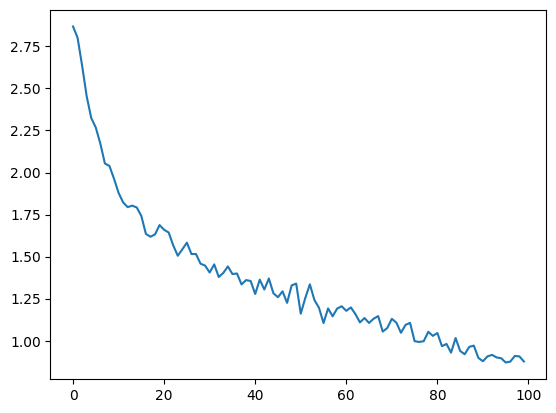

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\15432\AppData\Local\Temp\ipykernel_28804\3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\15432\AppData\Local\Temp\ipykernel_28804\3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


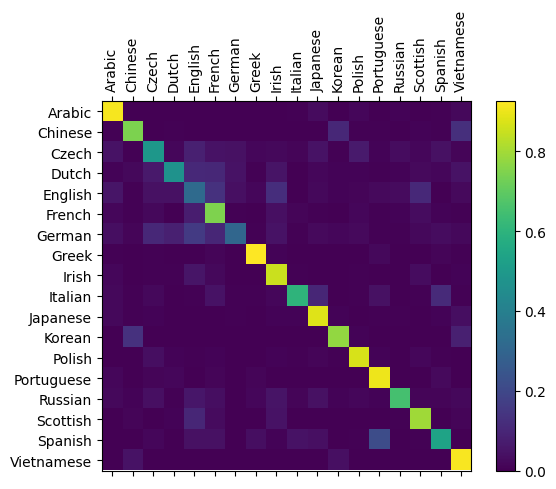

In [12]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [13]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.76) Irish
(-1.00) Russian
(-2.10) English

> Jackson
(-0.24) Scottish
(-1.98) English
(-2.86) Russian

> Satoshi
(-0.21) Japanese
(-1.81) Arabic
(-4.79) Italian


# GRU

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        self.guw1 = nn.Linear(input_size, hidden_size)
        self.guw2 = nn.Linear(hidden_size, hidden_size)
        self.grw1 = nn.Linear(input_size, hidden_size)
        self.grw2 = nn.Linear(hidden_size, hidden_size)
        self.outlayer = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_a, hidden):
        gr = F.sigmoid(self.grw1(input_a)+self.grw2(hidden))
        c_tmp = F.tanh(self.i2h(input_a) + gr*self.h2h(hidden))
        gu = F.sigmoid(self.guw1(input_a)+self.guw2(hidden))
        c = gu*c_tmp+(1-gu)*hidden
        output = self.outlayer(c)
        output = self.softmax(output)
        return output, c

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device="cpu"
rnn = GRU(n_letters, n_hidden, n_categories).to(device)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size
        
        self.gru=nn.GRU(input_size=input_size, hidden_size=128, num_layers=1, bias=True)
        self.lin=nn.Linear(hidden_size,output_size)
    def forward(self, input_a, hidden):
        output,h=self.gru(input_a,hidden)
        output=self.lin(output)
        return output, h

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
#device="cpu"
rnn = GRU(n_letters, n_hidden, n_categories).to(device)

In [8]:

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

learning_rate = 0.005
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)
 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden().to(device)
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].to(device), hidden)

    loss = criterion(output, category_tensor.to(device))
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    optimizer.step()
    optimizer.zero_grad()

    return output, loss.item()




('Greek', 7)
category = German / line = Sitz
category = Czech / line = Czabal
category = Czech / line = Janicek
category = Italian / line = Cremonesi
category = Czech / line = Mozzis
category = Irish / line = Domhnall
category = French / line = Granger
category = English / line = Fern
category = Arabic / line = Mifsud
category = Scottish / line = Duncan


In [9]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor.to(device), line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (1m 0s) 0.7705 Mozdzierz / Polish ✓
10000 10% (1m 59s) 0.7369 Pezos / Greek ✓
15000 15% (2m 58s) 0.0295 Maolmhuaidh / Irish ✓
20000 20% (3m 58s) 0.7445 Hughes / Scottish ✓
25000 25% (5m 1s) 1.7346 Hunter / German ✗ (Scottish)
30000 30% (6m 2s) 3.2626 Freedman / German ✗ (English)
35000 35% (7m 0s) 0.2695 Choe / Korean ✓
40000 40% (8m 1s) 0.9305 Colman / Irish ✓
45000 45% (9m 1s) 0.1090 Mackenzie / Scottish ✓
50000 50% (10m 3s) 0.0194 Riain / Irish ✓
55000 55% (11m 3s) 0.0026 Rahal / Arabic ✓
60000 60% (12m 3s) 3.1454 Abel / Dutch ✗ (Spanish)
65000 65% (13m 5s) 0.4741 Mcgregor / Scottish ✓
70000 70% (14m 6s) 0.0231 Black / Scottish ✓
75000 75% (15m 8s) 0.1513 Madaidhin / Irish ✓
80000 80% (16m 9s) 7.1988 Bokhoven / Russian ✗ (Dutch)
85000 85% (17m 12s) 1.1835 Dao / Chinese ✗ (Vietnamese)
90000 90% (18m 14s) 0.0026 Ritchie / Scottish ✓
95000 95% (19m 17s) 0.2372 Bachmeier / German ✓
100000 100% (20m 21s) 0.0444 Rosario / Portuguese ✓


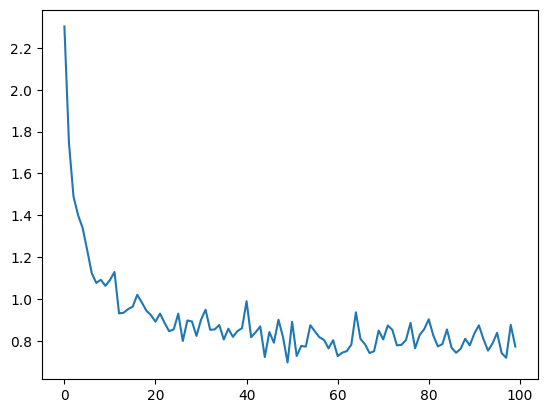

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\15432\AppData\Local\Temp\ipykernel_2064\2744540361.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\15432\AppData\Local\Temp\ipykernel_2064\2744540361.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


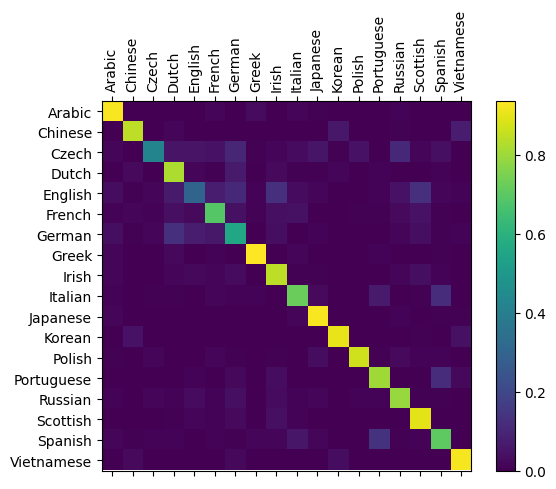

In [11]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().to(device)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i].to(device), hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
GRU相较于RNN，收敛速度更快，精准度更高。
对混淆矩阵进行对比，gru的正确预测率更高只有2个蓝色图像点，而RNN有四个蓝色图像点，在对角线上。
gru有一种类别精度小于0.5而RNN有2类小于0.5。可以看出gru的精准度更高。